## Smoking classification code for Tableau Dashboard

Objective:  This is code to predict the smoking probability of a person based on the input attributed provided.

In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import random
from scipy.stats import lognorm, loguniform, randint


# models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve

## Modelling with the gender feature

* In this code I will use the provided dataset and generate catergorical features and the gender feature.
* There is no 'gender' feature available in the provided kaggle dataset. I use another kaggle dataset to which has the same features and the gender features and fit a model to it.
* I used this model to generate the generate the gender feature on the kaggle dataset.
* The final train and test data will include: default features + generated categorical features + generated gender feature.
* I fit a model to predict smoking classification probability.
* This model will be exported as a pickle file to load into Tabpy for making predictions
* The user in the dashboard will enter values for the default features, categorical features will be generated through script functions, gender will be entered as user and interpreted as floating numerical 1 or 0 in the code.


In [8]:
# read the training data
df = pd.read_csv('../data/train.csv')

In [9]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=123)

In [10]:
train_df.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

## Creating the Gender feature

In [11]:
smoking = pd.read_csv('../data/other_data_smoking.csv',index_col='ID')

In [2]:
# imports

from sklearn.feature_selection import mutual_info_classif
from joblib import Parallel, delayed
from sklearn.preprocessing import OrdinalEncoder

In [13]:
def mi(x,y,n_iter=5):
    X = np.array(x).reshape((-1,1))
    y = np.array(y)
    if X.dtype == 'object':
        X = OrdinalEncoder().fit_transform(X)
    scores = Parallel(n_jobs=4)(delayed(mutual_info_classif)(X,y,random_state=42+i) for i in range(n_iter))
    return np.array([np.mean(scores), np.std(scores)])

def theil_u(train,target,comment=''):
    print(F'*** U(y|x) in % {comment} ***')
    e = mi(train[target],train[target])[0]
    for c in train.columns:
        if c != target:
            mu, sigma = mi(train[c],train[target])/e*100
            print(F"{c}: {mu:.2f} ± {sigma:.2f}")

theil_u(smoking,target='smoking',comment='(Original data)')

*** U(y|x) in % (Original data) ***
gender: 24.49 ± 0.28
age: 2.39 ± 0.29
height(cm): 15.97 ± 0.17
weight(kg): 8.44 ± 0.28
waist(cm): 4.87 ± 0.16
eyesight(left): 1.04 ± 0.26
eyesight(right): 1.21 ± 0.35
hearing(left): 0.97 ± 0.41
hearing(right): 1.00 ± 0.39
systolic: 1.02 ± 0.28
relaxation: 1.30 ± 0.16
fasting blood sugar: 0.84 ± 0.25
Cholesterol: 0.06 ± 0.10
triglyceride: 5.52 ± 0.38
HDL: 2.95 ± 0.36
LDL: 0.42 ± 0.28
hemoglobin: 15.63 ± 0.28
Urine protein: 1.03 ± 0.31
serum creatinine: 6.80 ± 0.19
AST: 1.17 ± 0.16
ALT: 3.25 ± 0.46
Gtp: 11.37 ± 0.13
oral: 0.22 ± 0.12
dental caries: 0.93 ± 0.30
tartar: 1.70 ± 0.28


In [15]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from xgboost import XGBClassifier

kfold = RepeatedStratifiedKFold(n_splits=10,n_repeats=5)
X_0 = smoking.drop(['gender','oral','tartar','smoking'],axis=1)
y_0 = smoking['gender'].map({'F':0,'M':1})

results = cross_validate(XGBClassifier(n_jobs=4,random_state=0),
                         X_0,y_0,
                         scoring='roc_auc',
                         cv=kfold,n_jobs=1,
                         return_estimator=True)

results['test_score'].mean(), results['test_score'].std()

(0.9973666995403222, 0.0003979063210049562)

In [16]:
# Generate male probability for the train data

train_df['male_probability'] = 0
cols = list(X_0.columns)

for clf in results['estimator']:
    train_df['male_probability'] += clf.predict_proba(train_df[cols])[:,1]
train_df['male_probability'] /= len(results['estimator'])

In [17]:
# Generate male probability for the test data

test_df['male_probability'] = 0
cols = list(X_0.columns)

for clf in results['estimator']:
    test_df['male_probability'] += clf.predict_proba(test_df[cols])[:,1]
test_df['male_probability'] /= len(results['estimator'])

In [18]:
# functions for feature engineering

def bmi_feat(df):
    ''' creates the bmi and the associated risk colum
    BMI < 18.5 - Underwieght
    BMI between 18.5- 24.99 - Normal
    BMI between 25- 29.99 - Overweight
    BMI between 30-34.99 - Obese- grade 1
    BMI between 35- 39.99 - Obese- grade 2
    BMI >= 40.00 - Obese- grade 3 
    '''
    
    
    bmi_ranges = [0, 18.5, 25, 30, 35, 40, float('inf')]
    bmi_levels = ['Underweight', 'Normal', 'Overweight', 'Obese-lvl1','Obese-lvl2', 'Obese-lvl3']
    
    df['bmi'] = df['weight(kg)'] / ((df['height(cm)']*0.01)**2)
    df['bmi_category'] = pd.cut(df['bmi'], bins = bmi_ranges, labels=bmi_levels, right=False)
    
    return df

def obesity_risk(df):
    ''' creates col for obesity risk based on waistline

        Waist circumference and obesity
        For men-
        below 94cm (37in) - low risk
        94–102cm (37-40in) - high risk
        more than 102cm (40in) - very high
        For women-
        below 80cm (31.5in) - low risk
        80–88cm (31.5-34.6in) - high risk
        more than 88cm (34.6in) - very high
    '''
        
    female = df['male_probability'] < 0.5
    male = df['male_probability'] >= 0.5
    
    male_waist_ranges = [0,94,102,float('inf')]
    female_waist_ranges = [0,80,88,float('inf')]
    
    waist_levels = ['low risk', 'high risk', 'very high risk']
    
    df['obesity_risk'] = np.where(female, pd.cut(df['waist(cm)'], bins=female_waist_ranges, labels=waist_levels), pd.cut(df['waist(cm)'], bins=male_waist_ranges, labels=waist_levels))
    
    return df

def age_risk(df):
    ''' risk based on age
        
        Age and health risk
        Age < 45 - lower risk
        Age >= 45 years - high risk 
    '''
    # for now computing with the solo gender info as men
    age_ranges = [0,45,float('inf')]
    age_levels = ['low risk', 'high risk']
    
    df['age_risk'] = pd.cut(df['age'], bins = age_ranges, labels=age_levels, right=False)
    
    return df


def bp_risk(df):
    '''
    calculates the bp risk
    
    Systolic BP < 120 mmHg or Diastolic BP < 80 mmHg - normal
    Systolic BP between 120 mmHg- 129 mmHg or Diastolic BP between 80-89 mmHg- elevated
    Systolic BP between 130 mmHg - 139 mmHg or Diastolic BP between 90-99 mmHg- stage 1 high BP
    Systolic BP between 140 mmHg - 179 mmHg or Diastolic BP between 100-119 mmHg- stage 2 high BP
    Systolic BP >= 180 mmHg or Diastolic BP >= 120 mmHg- stage 3 high BP (emergency)
        '''
    
    bp_ranges = [0,120,130,140,180,float('inf')]
    bp_levels = ['normal', 'elevated', 'high_lvl1', 'high_lvl2', 'high_lvl3']
    
    df['bp_risk'] = pd.cut(df['systolic'], bins = bp_ranges, labels=bp_levels, right=False)
    
    return df
    
    
def hdl_risk(df):
    '''
    Less then 40- High risk
    Between 40-60 - Normal
    Greater of equals 60- Low risk
    '''
    hdl_ranges = [0,40,60,float('inf')]
    hdl_levels = ['high risk', 'normal', 'low risk']
    
    df['hdl_risk'] = pd.cut(df['HDL'], bins = hdl_ranges, labels=hdl_levels, right=False)
    
    return df

def ldl_risk(df):
    '''
    Less than 100mg/dL- Optimal (best for your health)
    100-129mg/dL- Near optimal
    130-159 mg/dL- Borderline high
    160-189 mg/dL- High
    190 mg/dL and above- Very High
    '''
    ldl_ranges = [0,100,130,160,190,float('inf')]
    ldl_levels = ['optimal', 'normal', 'high_lvl1', 'high_lvl2', 'high_lvl3']
    
    df['ldl_risk'] = pd.cut(df['LDL'], bins = ldl_ranges, labels=ldl_levels, right=False)
    
    return df   

def tg_risk(df):
    '''
    Less than 150 - normal
    150- 199- moderate risk
    200-499- high risk
    500+ - very high risk 
    '''
    tg_ranges = [0,150,200,500,float('inf')]
    tg_levels = ['normal', 'moderate_risk', 'high_risk', 'very_high_risk']
    
    df['tg_risk'] = pd.cut(df['triglyceride'], bins = tg_ranges, labels=tg_levels, right=False)
    
    return df      

def anemic_risk(df):
    '''
    hemoglobin
    Less than 12
    '''
    
    hg_ranges = [0,12,float('inf')]
    hg_levels = ['high risk', 'low risk']
    
    df['anemic_risk'] = pd.cut(df['hemoglobin'], bins = hg_ranges, labels=hg_levels, right=False)
    
    return df   


def creatinine_range(df):
    '''
    For adult men - 0.74 to 1.35 mg/dL (65.4 to 119.3 micromoles/L)
    For adult women - 0.59 to 1.04 mg/dL (52.2 to 91.9 micromoles/L) 
    '''
    
    female = df['male_probability'] < 0.5
    male = df['male_probability'] >= 0.5
    
    female_cr_ranges = [0,0.60, 1.04, float('inf')]
    male_cr_ranges = [0,0.75, 1.35, float('inf')]
    cr_levels = ['low','normal', 'high']
    
    df['creatinine_cat'] = np.where(female, pd.cut(df['serum creatinine'], bins=female_cr_ranges, labels=cr_levels), pd.cut(df['serum creatinine'], bins=male_cr_ranges, labels=cr_levels))
    
    return df    


def gtp_range(df):
    '''
    normal range for adults is 5 to 40 U/L
    values above 40 are considered risky for liver disease 
    '''

    gtp_ranges = [0,5, 40, float('inf')]
    gtp_levels = ['low','normal', 'high']
    
    df['gtp_cat'] = pd.cut(df['Gtp'], bins = gtp_ranges, labels=gtp_levels, right=False)
    
    return df  


def ast_range(df):
    '''
    The normal range of an SGOT test is generally between 8 and 45 units per liter of serum
    Higher results indicate risk for liver disease    
    '''
    ast_ranges = [0,8, 45, float('inf')]
    ast_levels = ['low','normal', 'high']
    
    df['ast_cat'] = pd.cut(df['AST'], bins = ast_ranges, labels=ast_levels, right=False)
    
    return df  

def alt_range(df):
    '''
    The normal range of an alt test is generally between 29 to 33 
    international units per liter (IU/L) for males and 19 to 25 IU/L for females
    '''
    alt_ranges = [0,29, 33, float('inf')]
    alt_levels = ['low','normal', 'high']
    
    df['alt_cat'] = pd.cut(df['ALT'], bins = alt_ranges, labels=alt_levels, right=False)
    
    return df  

## Generating the categorical features on the train and test data 

In [19]:
# Feature engineering on train data
bmi_feat(train_df)
obesity_risk(train_df)
age_risk(train_df)
bp_risk(train_df)
hdl_risk(train_df)
ldl_risk(train_df)
tg_risk(train_df)
anemic_risk(train_df)
creatinine_range(train_df)
gtp_range(train_df)
ast_range(train_df)
alt_range(train_df)

# Feature engineering on the test data
bmi_feat(test_df)
obesity_risk(test_df)
age_risk(test_df)
bp_risk(test_df)
hdl_risk(test_df)
ldl_risk(test_df)
tg_risk(test_df)
anemic_risk(test_df)
creatinine_range(test_df)
gtp_range(test_df)
ast_range(test_df)
alt_range(test_df)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,age_risk,bp_risk,hdl_risk,ldl_risk,tg_risk,anemic_risk,creatinine_cat,gtp_cat,ast_cat,alt_cat
123726,123726,50,170,85,95.0,0.8,0.8,1,1,136,...,high risk,high_lvl1,low risk,optimal,normal,low risk,normal,high,high,high
70373,70373,40,160,55,65.0,0.6,0.8,1,1,100,...,low risk,normal,normal,high_lvl1,normal,high risk,normal,normal,normal,low
118032,118032,50,155,55,73.0,1.0,0.8,1,1,108,...,high risk,normal,low risk,optimal,normal,low risk,normal,normal,normal,low
21285,21285,40,175,80,91.0,1.0,1.2,1,1,120,...,low risk,elevated,normal,high_lvl2,normal,low risk,normal,high,normal,high
67141,67141,40,170,70,84.0,1.2,1.2,1,1,116,...,low risk,normal,high risk,normal,high_risk,low risk,normal,high,normal,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39999,39999,60,155,65,81.0,0.4,0.7,1,1,142,...,high risk,high_lvl2,low risk,normal,normal,low risk,normal,normal,normal,low
26648,26648,35,170,70,89.9,0.6,0.6,1,1,126,...,low risk,elevated,low risk,optimal,normal,low risk,normal,normal,normal,high
17709,17709,55,155,60,77.0,1.0,1.0,1,1,135,...,high risk,high_lvl1,normal,high_lvl1,high_risk,low risk,normal,normal,normal,high
45244,45244,50,150,50,64.0,0.9,1.2,1,1,119,...,high risk,normal,low risk,high_lvl1,normal,low risk,normal,normal,normal,low


## Separating into X and y components on the train and test data

In [20]:
X_train = train_df.drop(columns=["smoking", "id"])
y_train = train_df["smoking"]

X_test = test_df.drop(columns=["smoking", "id"])
y_test = test_df["smoking"]

In [21]:
# Optional export feature data
path = '../dashboard/data/'

if not os.path.exists(path):
    os.makedirs(path)

X_train.to_csv(f'{path}/X_train.csv')
y_train.to_csv(f'{path}/y_train.csv')
X_test.to_csv(f'{path}/X_test.csv')
y_test.to_csv(f'{path}/y_test.csv')

## Machine Learning

In [103]:
# read the processed data
path = '../dashboard/data/'

X_train = pd.read_csv(f'{path}/X_train.csv').drop(['Unnamed: 0'], axis = 1)
X_train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,age_risk,bp_risk,hdl_risk,ldl_risk,tg_risk,anemic_risk,creatinine_cat,gtp_cat,ast_cat,alt_cat
0,35,170,65,95.0,1.0,1.5,1,1,126,65,...,low risk,elevated,low risk,normal,normal,low risk,normal,high,normal,low
1,40,165,55,74.0,1.0,0.9,1,1,103,71,...,low risk,normal,normal,normal,normal,low risk,normal,normal,normal,low
2,55,155,65,79.0,0.7,0.6,1,1,133,83,...,high risk,high_lvl1,normal,normal,moderate_risk,low risk,low,normal,normal,low
3,60,150,55,77.0,0.8,1.0,1,1,150,80,...,high risk,high_lvl2,normal,normal,normal,low risk,low,normal,normal,low
4,60,165,90,101.0,0.8,0.8,1,1,120,75,...,high risk,elevated,high risk,normal,moderate_risk,low risk,normal,normal,normal,high


In [104]:
all_features = list(X_train.columns)
all_features

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries',
 'male_probability',
 'bmi',
 'bmi_category',
 'obesity_risk',
 'age_risk',
 'bp_risk',
 'hdl_risk',
 'ldl_risk',
 'tg_risk',
 'anemic_risk',
 'creatinine_cat',
 'gtp_cat',
 'ast_cat',
 'alt_cat']

In [105]:
drop_features = []
categorical_features = ['hearing(left)', 'hearing(right)']
ordinal_features = [ 'bmi_category',
 'obesity_risk',
 'age_risk',
 'bp_risk',
 'hdl_risk',
 'ldl_risk',
 'tg_risk',
 'anemic_risk',
 'creatinine_cat',
 'gtp_cat',
 'ast_cat',
 'alt_cat']
numerical_features = list(set(all_features) - set(drop_features) - set(ordinal_features) - set(categorical_features)) 

In [106]:
X_train.isnull().sum()


age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
male_probability       0
bmi                    0
bmi_category           0
obesity_risk           0
age_risk               0
bp_risk                0
hdl_risk               0
ldl_risk               0
tg_risk                0
anemic_risk            0
creatinine_cat         0
gtp_cat                0
ast_cat                0
alt_cat                0
dtype: int64

In [107]:
# Establising the ordering for each of the ordinal columns

ordinal_order=[
    ['Underweight', 'Normal', 'Overweight', 'Obese-lvl1','Obese-lvl2', 'Obese-lvl3'],
    ['low risk', 'high risk', 'very high risk'],
    ['low risk', 'high risk'],
    ['normal', 'elevated', 'high_lvl1', 'high_lvl2', 'high_lvl3'],
    ['low risk', 'normal', 'high risk'],
    ['optimal', 'normal', 'high_lvl1', 'high_lvl2', 'high_lvl3'],
    ['normal', 'moderate_risk', 'high_risk', 'very_high_risk'],
    ['low risk', 'high risk'],
    ['low','normal', 'high'],
    ['low','normal', 'high'],
    ['low','normal', 'high'],
    ['low','normal', 'high']
]

In [132]:
# Make pipeline

numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer_reg = make_pipeline(
    OrdinalEncoder(categories=ordinal_order),
)

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numerical_features),
    (ordinal_transformer_reg, ordinal_features),
    (categorical_transformer, categorical_features),
)

In [133]:
preprocessor.fit(X_train)

C:\Users\ranji\miniconda3\envs\smoking\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('drop', 'drop', []),
                                ('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['waist(cm)', 'male_probability', 'Gtp', 'ALT',
                                  'HDL', 'relaxation', 'height(cm)', 'age',
                                  'dental caries', 'bmi', 'serum creatinine',
                                  'weight(kg)', 'hemoglobin', 'Cholesterol',
                                  'eyesight(right)', 'triglyceride',
                                  'Urine protein', 'systolic', 'LDL',
                                  'eyes...
                                                                              'normal',
                                                                              'high'],
                                                                             ['low',
                                                                              'normal',
                                                                              'high'],
                                                                             ['low',
                                                                              'normal',
                                                                              'high']]))]),
                                 ['bmi_category', 'obesity_risk', 'age_risk',
                                  'bp_risk', 'hdl_risk', 'ldl_risk', 'tg_risk',
                                  'anemic_risk', 'creatinine_cat', 'gtp_cat',
                                  'ast_cat', 'alt_cat']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['hearing(left)', 'hearing(right)'])])

In [134]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)

In [135]:
ohe_columns

['hearing(left)_1', 'hearing(left)_2', 'hearing(right)_1', 'hearing(right)_2']

In [136]:
new_columns = (
    numerical_features + ordinal_features + ohe_columns
)

In [137]:
new_columns

['waist(cm)',
 'male_probability',
 'Gtp',
 'ALT',
 'HDL',
 'relaxation',
 'height(cm)',
 'age',
 'dental caries',
 'bmi',
 'serum creatinine',
 'weight(kg)',
 'hemoglobin',
 'Cholesterol',
 'eyesight(right)',
 'triglyceride',
 'Urine protein',
 'systolic',
 'LDL',
 'eyesight(left)',
 'fasting blood sugar',
 'AST',
 'bmi_category',
 'obesity_risk',
 'age_risk',
 'bp_risk',
 'hdl_risk',
 'ldl_risk',
 'tg_risk',
 'anemic_risk',
 'creatinine_cat',
 'gtp_cat',
 'ast_cat',
 'alt_cat',
 'hearing(left)_1',
 'hearing(left)_2',
 'hearing(right)_1',
 'hearing(right)_2']

In [138]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc.head()

,waist(cm),male_probability,Gtp,ALT,HDL,relaxation,height(cm),age,dental caries,bmi,...,tg_risk,anemic_risk,creatinine_cat,gtp_cat,ast_cat,alt_cat,hearing(left)_1,hearing(left)_2,hearing(right)_1,hearing(right)_2
0,1.341170,0.708873,0.732281,-0.540913,1.080232,-1.322063,0.536615,-0.785625,-0.494797,-0.580427,...,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-1.002555,0.651688,0.057392,-0.313778,0.221995,-0.653915,-0.029593,-0.363735,-0.494797,-1.260426,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.444526,-1.515668,-0.810323,0.026924,-0.922321,0.682381,-1.162009,0.901935,-0.494797,0.775158,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.667738,-1.509498,-0.681772,-0.370562,0.221995,0.348307,-1.728217,1.323825,2.021031,-0.000300,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,2.010805,0.705237,-0.103296,0.992246,-1.709038,-0.208483,-0.029593,1.323825,-0.494797,2.558138,...,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0


## LGBM model pipeline

In [141]:
X_train_enc['anemic_risk'].values

array([0., 0., 0., ..., 0., 0., 0.])

In [142]:
y_train = pd.read_csv(f'{path}/y_train.csv').drop(['Unnamed: 0'], axis = 1)

In [143]:
pipe_lgbm = make_pipeline(
    preprocessor, LGBMClassifier(random_state=123)
)

param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    "lgbmclassifier__max_depth": randint(2, 20),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    verbose=1,
    n_jobs=-1,
    scoring='roc_auc',
    random_state=123,
    return_train_score=True,
)



In [144]:
random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\ranji\miniconda3\envs\smoking\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\ranji\miniconda3\envs\smoking\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ranji\miniconda3\envs\smoking\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 55704, number of negative: 71700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437223 -> initscore=-0.252439
[LightGBM] [Info] Start training from score -0.252439


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               []),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['waist(cm)',
                                                                                'male_probability',
                                                                                'Gtp',
                                                                                'ALT',
                                                                                'HDL',
                                                                                'relaxation',
                                                                                'height(cm)',
                                                                                'age',
                                                                                'dental '
                                                                                'caries',
                                                                                'bmi',
                                                                                'serum '
                                                                                'creatinine',
                                                                                'weight(kg)',
                                                                                'hemoglobin',
                                                                                'Cholesterol',...
                   param_distributions={'lgbmclassifier__learning_rate': [0.01,
                                                                          0.1],
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E343257C0>,
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E6BBAF470>,
                                        'lgbmclassifier__subsample': [0.5, 0.75,
                                                                      1]},
                   random_state=123, return_train_score=True, scoring='roc_auc',
                   verbose=1)

In [121]:
# utility function to report the best results from
# Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")
            
    return

report(random_search_lgbm.cv_results_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [120]:
# Get the best estimatore

best_lgbm = random_search_lgbm.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [22]:
# Read the test data and make predictions to check the performance

X_test = pd.read_csv(f'{path}/X_test.csv').drop(['Unnamed: 0'], axis = 1)
y_test = pd.read_csv(f'{path}/y_test.csv').drop(['Unnamed: 0'], axis = 1)

In [23]:
# Get predictions

pred = best_lgbm.predict(X_test)
pred_proba = best_lgbm.predict_proba(X_test)[:,1]

# Getting the roc_auc score on the predictions
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, pred_proba)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.8638851666643195

## Plot the ROC curve

In [24]:
# plotting the roc curve

# utility function from
# https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    return

Threshold value is: 0.44401374822913137


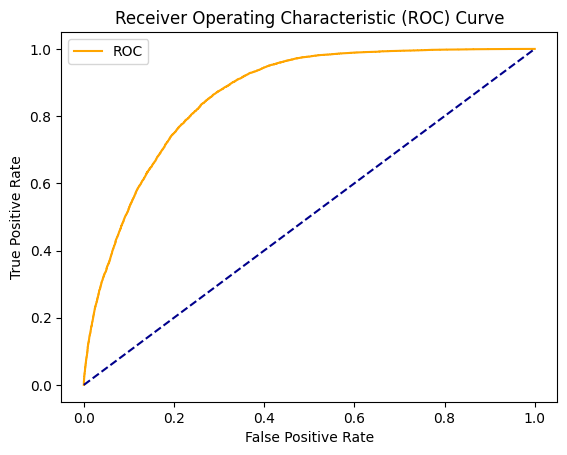

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

## Export model to pickle file

In [26]:
# exporting the model to a pickle file

import pickle

# save the model to disk
model_path = '../dashboard/saved_models'
if not os.path.exists(model_path):
    os.makedirs(model_path)

filename = 'lgbm_model_gender'
pickle.dump(best_lgbm, open(model_path+'/'+filename, 'wb'))

## Scripts for Tabpy

In [27]:
X_test.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'male_probability', 'bmi',
       'bmi_category', 'obesity_risk', 'age_risk', 'bp_risk', 'hdl_risk',
       'ldl_risk', 'tg_risk', 'anemic_risk', 'creatinine_cat', 'gtp_cat',
       'ast_cat', 'alt_cat'],
      dtype='object')

In [52]:
'''
inp_list = [_arg1[0], _arg1[1]....

# These are the parameters to be input by user (need to check if name needs to match model columns??)
# default features
[age, height(cm), 'weight(kg)', 'waist(cm)',
'eyesight(left)', 'eyesight(right)', 'hearing(left)',
'hearing(right)', 'systolic','relaxation',
'fasting blood sugar', 'Cholesterol', 'triglyceride',
'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
'ALT', 'Gtp', 'dental caries', 'gender']

# backend computed features
[bmi', 'bmi_category', 'obesity_risk', 'age_risk', 'bp_risk', 'hdl_risk',
'ldl_risk', 'tg_risk', 'anemic_risk', 'creatinine_cat', 'gtp_cat',
'ast_cat', 'alt_cat']

# all features = default + computed features (in exact same order)
'''

"\ninp_list = [_arg1[0], _arg1[1]....\n\n# These are the parameters to be input by user (need to check if name needs to match model columns??)\n# default features\n[age, height(cm), 'weight(kg)', 'waist(cm)',\n'eyesight(left)', 'eyesight(right)', 'hearing(left)',\n'hearing(right)', 'systolic','relaxation',\n'fasting blood sugar', 'Cholesterol', 'triglyceride',\n'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',\n'ALT', 'Gtp', 'dental caries', 'gender']\n\n# backend computed features\n[bmi', 'bmi_category', 'obesity_risk', 'age_risk', 'bp_risk', 'hdl_risk',\n'ldl_risk', 'tg_risk', 'anemic_risk', 'creatinine_cat', 'gtp_cat',\n'ast_cat', 'alt_cat']\n\n# all features = default + computed features (in exact same order)\n"

In [72]:
d = {
'weight(kg)': [1],
'height(cm)': [2]
}

In [77]:
pd.DataFrame(d)['weight(kg)'][0]

1

In [96]:
inp_dict = {
'age':31,
'height(cm)':165,
'weight(kg)':60,
'waist(cm)':75,
'eyesight(left)':1,
'eyesight(right)':1,
'hearing(left)':1,
'hearing(right)':1,
'systolic':20,
'relaxation':20,
'fasting blood sugar':100,
'Cholesterol':122,
'triglyceride':150,
'HDL':100,
'LDL':100,
'hemoglobin':10,
'Urine protein':10,
'serum creatinine':10,
'AST':10,
'ALT':10,
'Gtp':6,
'dental caries':1,
'male_probability':1,
'bmi':25,
'bmi_category':'Underweight',
'obesity_risk':'low risk',
'age_risk':'low risk',
'bp_risk':'normal',
'hdl_risk':'low risk',
'ldl_risk':'optimal',
'tg_risk':'normal',
'anemic_risk':'high risk',
'creatinine_cat':'high',
'gtp_cat':'high',
'ast_cat':'high',
'alt_cat':'low'
}

In [97]:
inp_df = pd.DataFrame(inp_dict, index = [0])

In [98]:
inp_df['bmi_category']

0    Underweight
Name: bmi_category, dtype: object

In [99]:
best_lgbm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', []),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['waist(cm)',
                                                   'male_probability', 'Gtp',
                                                   'ALT', 'HDL', 'relaxation',
                                                   'height(cm)', 'age',
                                                   'dental caries', 'bmi',
                                                   'serum creatinine',
                                                   'weight(kg)', 'hemoglobin',
                                                   'Cholesterol',
                                                   'eyesight(right)',
                                                   'triglyceride',...
                                                   'obesity_risk', 'age_risk',
                                                   'bp_risk', 'hdl_risk',
                                                   'ldl_risk', 'tg_risk',
                                                   'anemic_risk',
                                                   'creatinine_cat', 'gtp_cat',
                                                   'ast_cat', 'alt_cat']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['hearing(left)',
                                                   'hearing(right)'])])),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=19, n_estimators=96, random_state=123,
                                subsample=0.75))])

In [100]:
best_lgbm.named_steps['columntransformer'].get_feature_names_out()

array(['pipeline-1__waist(cm)', 'pipeline-1__male_probability',
       'pipeline-1__Gtp', 'pipeline-1__ALT', 'pipeline-1__HDL',
       'pipeline-1__relaxation', 'pipeline-1__height(cm)',
       'pipeline-1__age', 'pipeline-1__dental caries', 'pipeline-1__bmi',
       'pipeline-1__serum creatinine', 'pipeline-1__weight(kg)',
       'pipeline-1__hemoglobin', 'pipeline-1__Cholesterol',
       'pipeline-1__eyesight(right)', 'pipeline-1__triglyceride',
       'pipeline-1__Urine protein', 'pipeline-1__systolic',
       'pipeline-1__LDL', 'pipeline-1__eyesight(left)',
       'pipeline-1__fasting blood sugar', 'pipeline-1__AST',
       'pipeline-2__bmi_category', 'pipeline-2__obesity_risk',
       'pipeline-2__age_risk', 'pipeline-2__bp_risk',
       'pipeline-2__hdl_risk', 'pipeline-2__ldl_risk',
       'pipeline-2__tg_risk', 'pipeline-2__anemic_risk',
       'pipeline-2__creatinine_cat', 'pipeline-2__gtp_cat',
       'pipeline-2__ast_cat', 'pipeline-2__alt_cat',
       'pipeline-3__hearing(l

In [102]:
pd.DataFrame(best_lgbm.named_steps['columntransformer'].transform(inp_df), columns=best_lgbm.named_steps['columntransformer'].get_feature_names_out())['pipeline-2__bmi_category']

0    0.0
Name: pipeline-2__bmi_category, dtype: float64

In [95]:
best_lgbm.predict_proba(inp_df)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([[0.71466121, 0.28533879]])